# Comparing Adversarial robustness performance
This notebook meta learns plasticity rules on an 8 dimensional halfspace, and then runs adversarial robustness performance on MNIST data

In [67]:
%run FF_common.ipynb

In [74]:
from torchviz import make_dot
from AdversarialExamples import adversarial_example, random_not_true_label
%load_ext autoreload
%autoreload 2
# A function to manually switch graadient computation on for every single parameter in the network, 
# even if we arent updating them

def enable_grad_everywhere(model):
    # Turn on requires_grad everywhere by converting to parameters.
    for i,hidden_weight in enumerate(model.hidden_weights):
        if hidden_weight is not None:
            model.hidden_weights[i] = torch.nn.Parameter( hidden_weight )

        model.hidden_biases[i] = torch.nn.Parameter(model.hidden_biases[i] )

    #model.graph_weights = torch.nn.Parameter( model.graph_weights )
    #model.graph_bias = torch.nn.Parameter( model.graph_bias )
    model.input_weights = torch.nn.Parameter( model.input_weights )
    model.output_weights = torch.nn.Parameter( model.output_weights )
    model.output_bias = torch.nn.Parameter( model.output_bias )
    

def plot_random_adversary(brain_model, example_index=768,perturb_level=3,show_grad=False):
    ####################################
    # Try different values of example_index and perturb_level to see how the image changes and what it's meant to look like
    ####################################
    print("****Getting Data****")
    X_train, y_train, X_test, y_test = quick_get_data('mnist', n_down)
    examp_X = torch.from_numpy(X_test[example_index]).double()
    examp_Y = y_test[example_index]
    not_Y = random_not_true_label(examp_Y)
    print("****Turning on Gradients****")
    enable_grad_everywhere(brain_model)
    print("****Creating Adversary****")
    adv_X = adversarial_example(
        examp_X.reshape(1, -1), torch.tensor([not_Y], dtype=torch.long), 
        brain_model.forward_pass, eps=perturb_level, lr=1e-3,verbose=True,show_grad=show_grad)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(examp_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[0].set_title( 'Original - '+ str(examp_Y))
    ax[1].imshow(adv_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[1].set_title( "Makes NN think it's - " + str(not_Y))
    plt.show()
    
def visualize_model(brain_model):
    
    x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
    out = brain_model.forward_pass(x)
    make_dot(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
n_up = 8  # Input layer size for meta-learning.
n_down = 784  # Input layer size for desired task training.
m_up = 2  # Output layer size.
m_down = 10
l = 2  # Number of hidden layers.
w = 32  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 16  # Number of nodes firing per layer.
dataset_up = 'halfspace'
dataset_down = 'mnist'

# Training config.
num_runs = 1
num_rule_epochs = 50
num_epochs_upstream = 1
num_epochs_downstream = 1

In [70]:
brain_prepost_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_up, update_scheme=scheme)
brain_prepost_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_down, update_scheme=scheme)

In [71]:
stats, brain_prepost_trained = evaluate_generalization(
    brain_prepost_up_fact, 
    brain_prepost_down_fact, 
    n_up, 
    n_down, 
    dataset_up='halfspace',dataset_down='mnist', 
    num_runs=1, 
    num_rule_epochs=20, 
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,get_model=True
)

  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


Run 1 / 1...
Meta-learning on halfspace...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Last loss: 0.4332
Last train accuracy: 0.8893
Last test accuracy: 0.9080
mnist_train: 60000
mnist_test: 10000
Training NEW brain instance (WITH backprop) on mnist...
INITIAL train accuracy: 0.0987
INITIAL test accuracy: 0.0980
Epoch 1 / 1 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [04:33<00:00, 219.02it/s]


Last loss: 2.1372
Last train accuracy: 0.3309
Last test accuracy: 0.3269



****Getting Data****
mnist_train: 60000
mnist_test: 10000
****Turning on Gradients****
****Creating Adversary****
Loss/cnt/eps_curr/Y: 2.461150171734475 1 0.2663270473470781 1
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Loss/cnt/eps_curr/Y: 2.461150171734475 89 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 90 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 91 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 92 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 93 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 94 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 95 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 96 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 97 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 98 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 99 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.461150171734475 100 0.2663270473470781 1
too many steps to create adversary. Exiting.


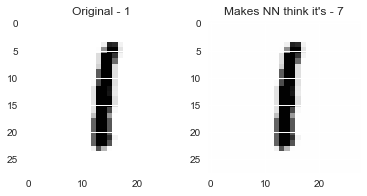

In [75]:
plot_random_adversary(brain_prepost_trained,show_grad=True)

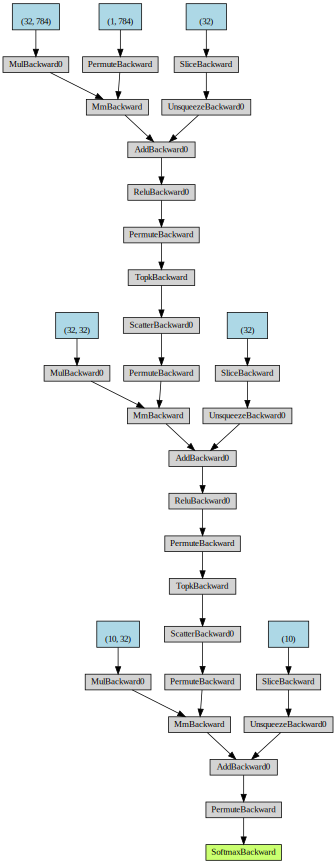

In [78]:
x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
out = brain_prepost_trained.forward_pass(x)
make_dot(out)

In [35]:
params = brain_trained.named_parameters()
for p in params:
    print(p)

('input_weights', Parameter containing:
tensor([[ 0.6485,  0.4050,  0.8624,  ..., -0.5329, -0.6730,  0.5667],
        [-0.8807,  0.7314, -2.2592,  ...,  1.0843, -0.7097,  0.0980],
        [ 0.5151, -1.6124, -0.6101,  ...,  0.5293, -0.5434,  0.3631],
        ...,
        [ 0.2707, -0.7338,  0.6043,  ..., -0.4316, -0.2202,  0.1298],
        [ 1.3474, -0.1016,  1.5066,  ..., -0.1209, -1.0846,  1.9291],
        [ 0.2280, -0.8931, -1.2164,  ...,  0.1385,  0.8771,  2.3653]],
       dtype=torch.float64, requires_grad=True))


In [50]:
# Instantiate brain factories.
#brain_fullgd_up_fact = lambda: FFBrainNet(n_up, m_up, l, w, p, cap,full_gd=True,gd_input=True,gd_output=True)
brain_fullgd_down_fact = lambda: FFBrainNet(n_down, m_down, l, w, p, cap,full_gd=True,gd_input=True,gd_output=True)

In [52]:
brain_down = brain_fullgd_down_fact()
X_train, y_train, X_test, y_test = quick_get_data(dataset_down, n_down)
print('Training NEW brain instance (WITH backprop) on ' + dataset_down + '...')
stats_down = train_downstream(
    X_train, y_train, brain_down, num_epochs=num_epochs_downstream,
    batch_size=100, vanilla=True, learn_rate=5e-3,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=500)

mnist_train: 60000
mnist_test: 10000
Training NEW brain instance (WITH backprop) on mnist...
INITIAL train accuracy: 0.1267
INITIAL test accuracy: 0.1281
Epoch 1 / 1 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:41<00:00,  5.90it/s]


Last loss: 1.5412
Last train accuracy: 0.9232
Last test accuracy: 0.9209


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5
Loss/cnt/eps_curr/Y: 2.4611446066319758 1 0.2663270473470781 1
Loss/cnt/eps_curr/Y: 2.4609601800952743 2 0.4512116584835643 1
Loss/cnt/eps_curr/Y: 2.460372468843355 3 0.5789802532742583 1
Loss/cnt/eps_curr/Y: 2.4578854771983725 4 0.7118145988343343 1
Loss/cnt/eps_curr/Y: 2.4493122167768604 5 0.8504066895329953 1
Loss/cnt/eps_curr/Y: 2.429392453430526 6 0.9917365408762259 1


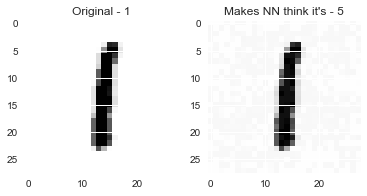

In [59]:
from AdversarialExamples import adversarial_example, random_not_true_label
%load_ext autoreload
%autoreload 2

####################################
# Try different values of example_index and perturb_level to see how the image changes and what it's meant to look like
####################################
example_index = 768
perturb_level = 1
examp_X = torch.from_numpy(X_test[example_index]).double()
examp_Y = y_test[example_index]
not_Y = random_not_true_label(examp_Y)
print(not_Y)
adv_X = adversarial_example(
    examp_X.reshape(1, -1), torch.tensor([not_Y], dtype=torch.long), 
    brain_down.forward_pass, eps=perturb_level, lr=1e-2,verbose=True)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(examp_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
ax[0].set_title( 'Original - '+ str(examp_Y))
ax[1].imshow(adv_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
ax[1].set_title( "Makes NN think it's - " + str(not_Y))
plt.show()

In [61]:
from AdversarialExamples import epsilon_sensitivity_trend
%load_ext autoreload
%autoreload 2

models = {
    'Full GD' : brain_down,
}

trend, epsilons = epsilon_sensitivity_trend(models,zip(X_test,y_test),brain_down.m,limit=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9209
Acc of class 0 : 1.0000
Acc of class 1 : 1.0000
Acc of class 2 : 1.0000
Acc of class 3 : 1.0000
Acc of class 4 : 1.0000
Acc of class 5 : 1.0000
Acc of class 6 : 1.0000
Acc of class 7 : 1.0000
Acc of class 8 : 1.0000
Acc of class 9 : 1.0000
**************** EPS:  0.0
ACC:  (1.0, array([7, 2, 1, 0, 4, 1, 4, 9, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6,
       5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 7, 2, 7, 1, 1, 1, 7, 4, 2, 3, 5, 1,
       2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 4, 3, 0,
       7, 0, 2, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9,
       3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9], dtype=int64))
Acc of class 0 : 1.0000
Acc of class 1 : 0.9286
Acc of class 2 : 0.7143
Acc of class 3 : 0.8182
Acc of class 4 : 0.9286
Acc of class 5 : 0.8571
Acc of class 6 : 0.8000
Acc of class 7 : 0.8667
Acc of class 8 : 1.0000
Acc of class 9 : 0.6364
**************** EPS:  0.5
ACC:  (0.85

KeyboardInterrupt: 

In [36]:
for model_name, series in trend.items():
    plt.plot(epsilons,series, label=model_name)
plt.legend()
plt.show()

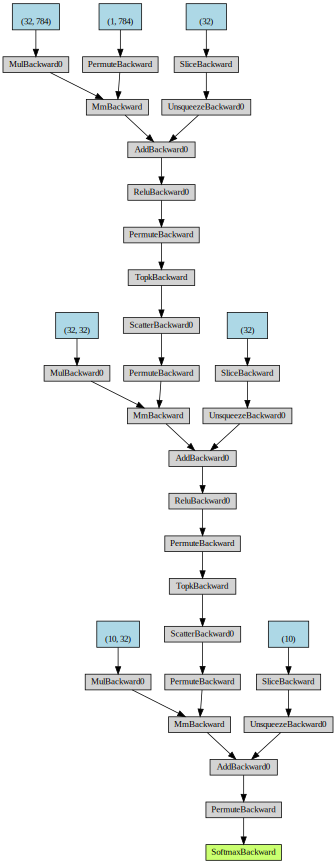

In [79]:
x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
out = brain_down.forward_pass(x)
make_dot(out)